In [1]:
import torch
from torch.autograd import grad
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi

In [4]:
class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
        return torch.cat([qqd[:,self.n:], qdd], 1)
    def _lagrangian(self, qqd):
        return self.L(qqd)    
    def energy(self, qqd):
        n = qqd.shape[1]//2
        lag = self.L(qqd)
        lag_sum = lag.sum()
        lag_grad = grad(lag_sum, qqd, create_graph=False)[0] ;
        DL_q, DL_qd = lag_grad[:,:n], lag_grad[:,n:]
        dq = qqd[:,n:]
        inner_prod = (dq*DL_qd).sum(1, keepdim=True)
        energy = lag - inner_prod
        return energy 

In [5]:
import time
input_size = 4
hidden_size = 200
output_size = 1
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range (num_trials):
  l_nn = LNN(nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,output_size))
         ).to(device)

  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=l_nn.parameters(),lr=0.0001)

  history_loss = []
  history_eval = []
  history_acc = []
  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    l_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = l_nn.forward(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt
      

    num_correct = 0
    num_data = 0
    l_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = l_nn.forward(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)
    
    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/lnn_ms_min_{}".format(trial)
      torch.save(l_nn.state_dict(), path)      
  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  print("When the training loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_train_index,num_epochs,min_total_loss_in_tl,min_evaluation_loss_in_tl))
  print("When the evaluation loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_evaluation_index,num_epochs,min_total_loss_in_el,min_evalation_loss_in_el))
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.009473923069890589,evaluation loss:0.009531554952263831
When the training loss value is smallest: 1946/2000 min training loss:0.009473792545031756, min evalation loss:0.009532233420759439
When the evaluation loss value is smallest: 2000/2000 min training loss:0.009473923069890589, min evalation loss:0.009531554952263831
2000/2000 training loss:0.00947590145515278,evaluation loss:0.00953188338316977
When the training loss value is smallest: 1951/2000 min training loss:0.009474005200900137, min evalation loss:0.00953178694471717
When the evaluation loss value is smallest: 1987/2000 min training loss:0.009476285963319241, min evalation loss:0.009531746292486787
2000/2000 training loss:0.009475169924553484,evaluation loss:0.009531863126903772
When the training loss value is smallest: 1924/2000 min training loss:0.009473873220849782, min evalation loss:0.00953287803567946
When the evaluation loss value is smallest: 1981/2000 min training loss:0.009475301287602633, 

In [7]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
# A = np.mat(A) `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
# B = np.mat(B)
A = np.asmatrix(A)
B = np.asmatrix(B)

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


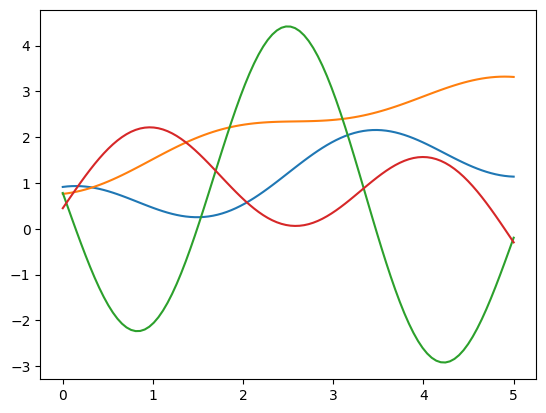

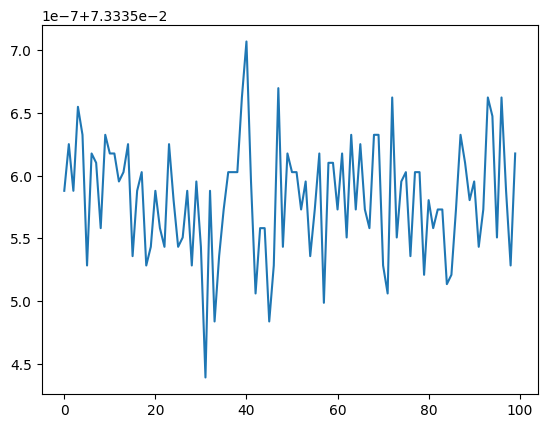

energy error:[2.9802322e-08]
energy_error0:-0.15736988909905714


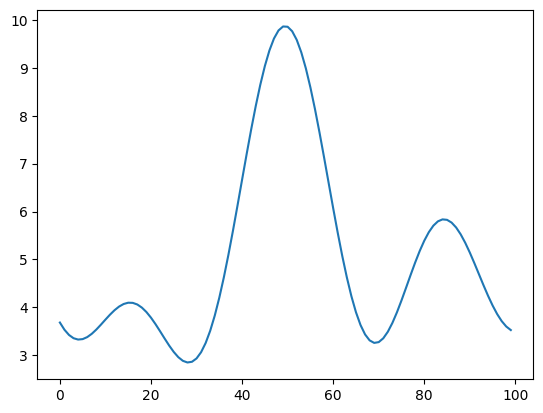

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


/tmp/ipykernel_20432/855741393.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_20432/855741393.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


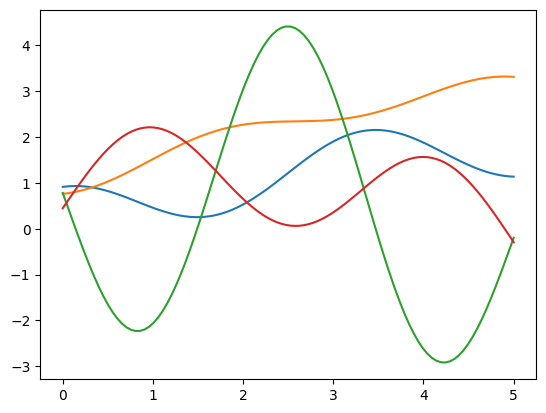

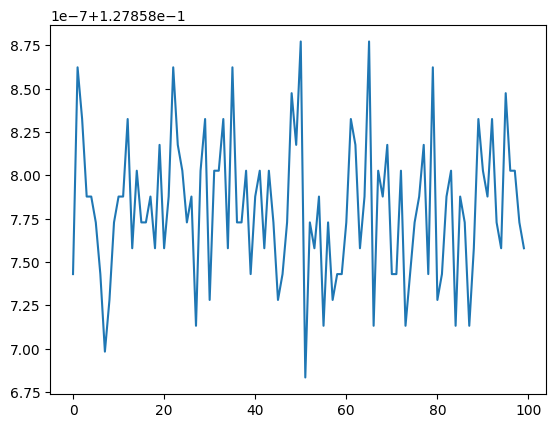

energy error:[1.4901161e-08]
energy_error1:-0.1503445251754032


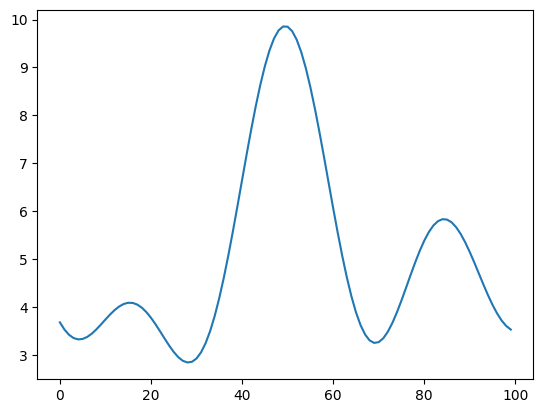

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


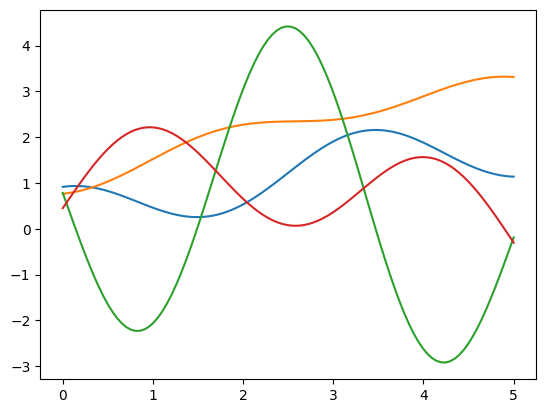

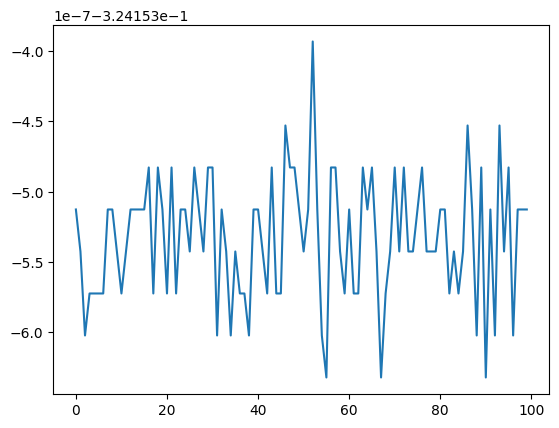

energy error:[0.]
energy_error2:-0.15289664332588826


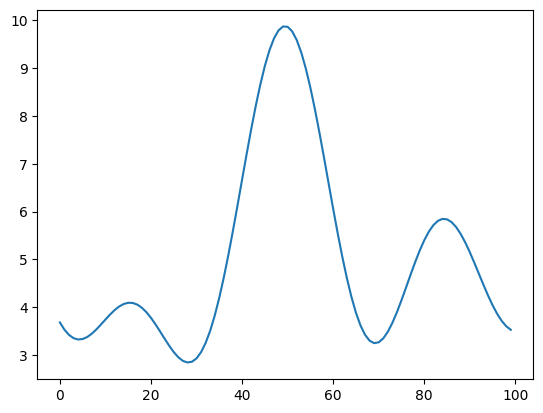

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


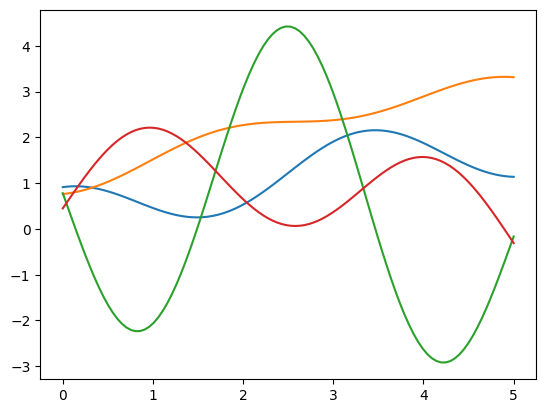

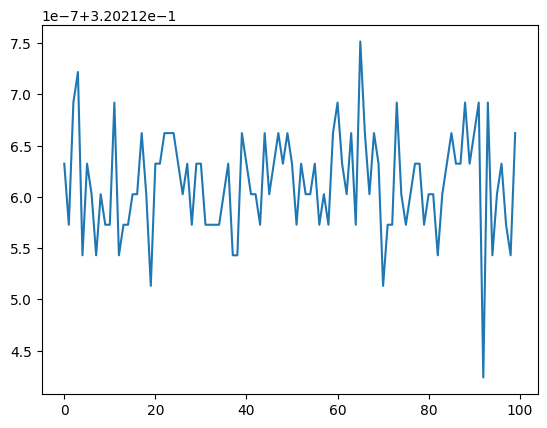

energy error:[2.9802322e-08]
energy_error3:-0.14957883554955398


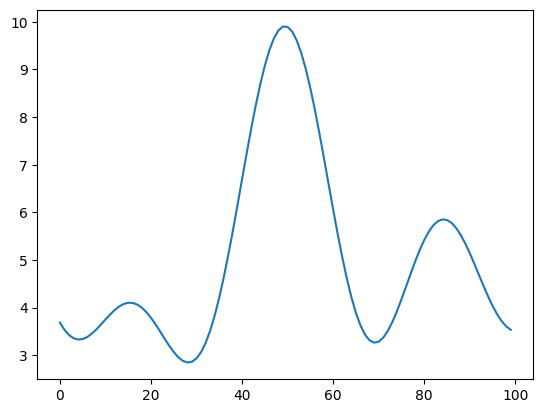

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


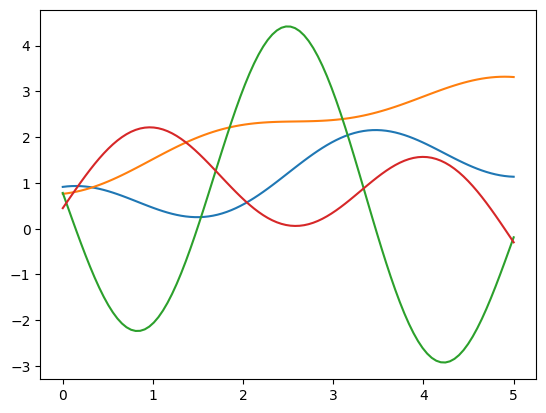

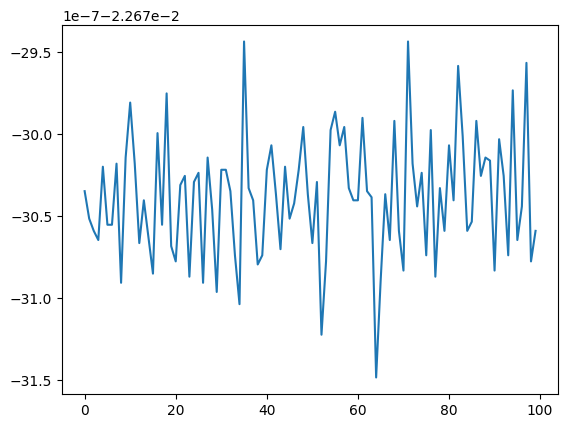

energy error:[-2.4214387e-08]
energy_error4:-0.14693782726418503


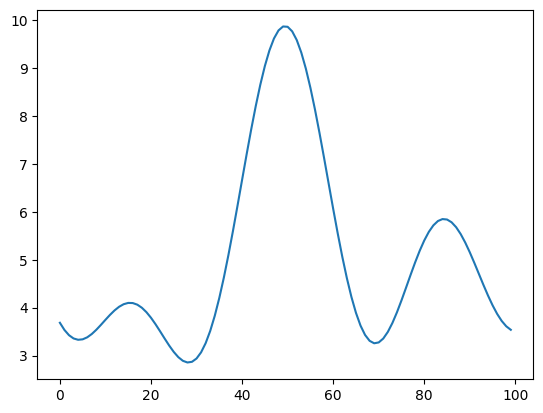

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


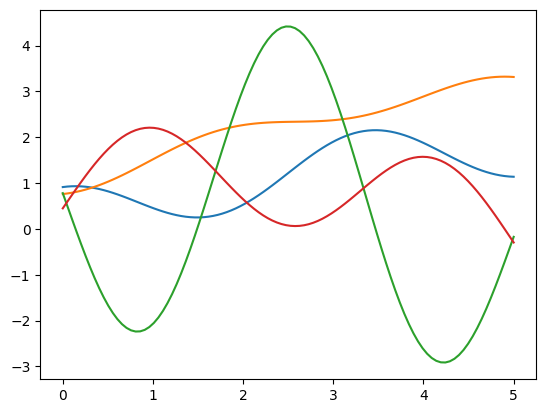

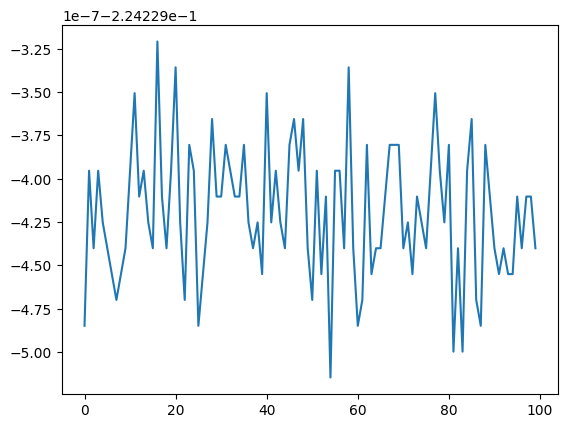

energy error:[4.4703484e-08]
energy_error5:-0.15216917819311693


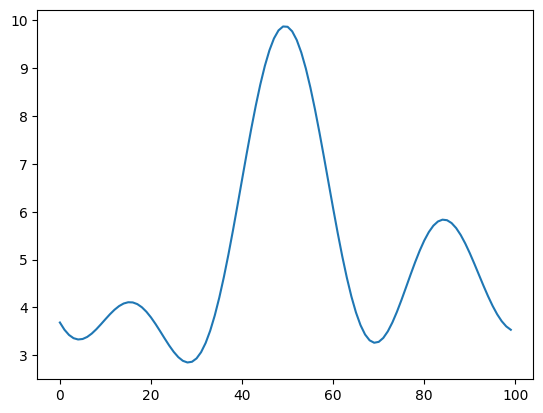

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


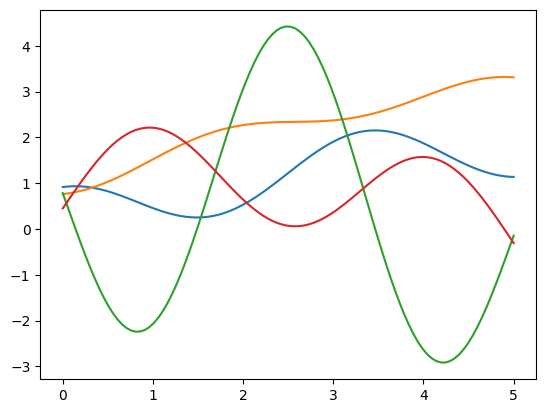

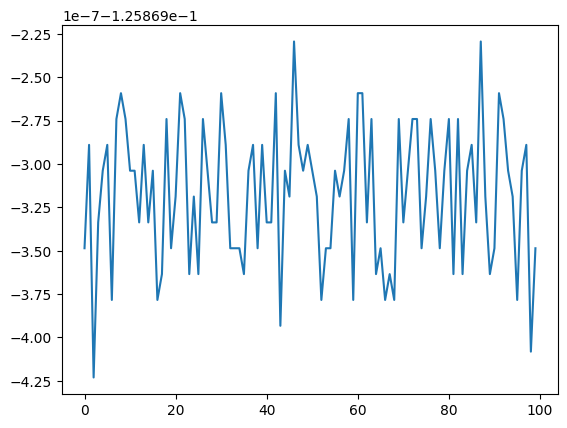

energy error:[0.]
energy_error6:-0.17381268425790397


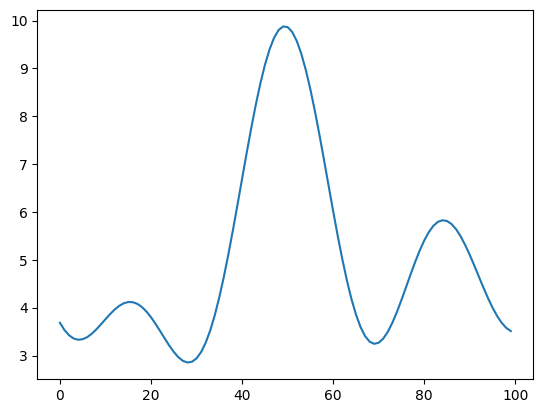

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


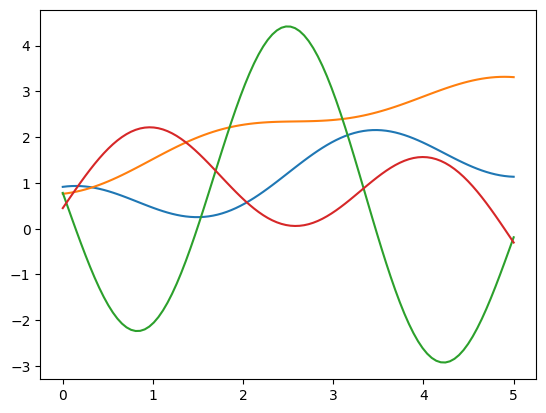

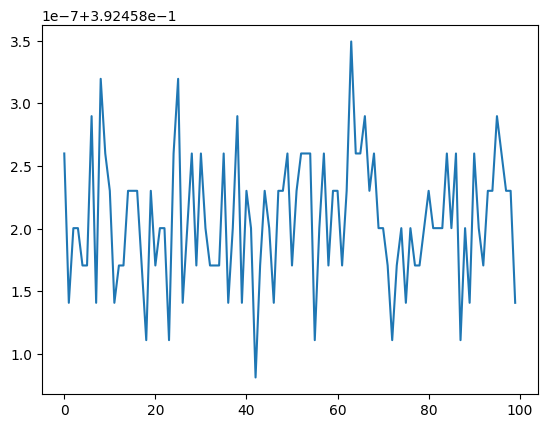

energy error:[-1.1920929e-07]
energy_error7:-0.16156277001094566


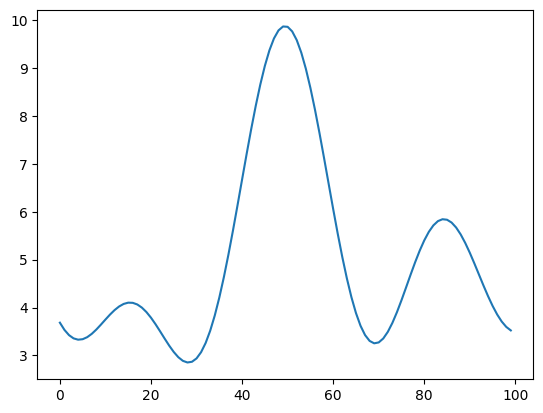

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


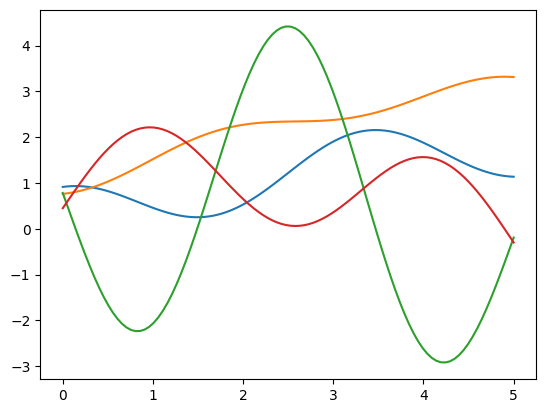

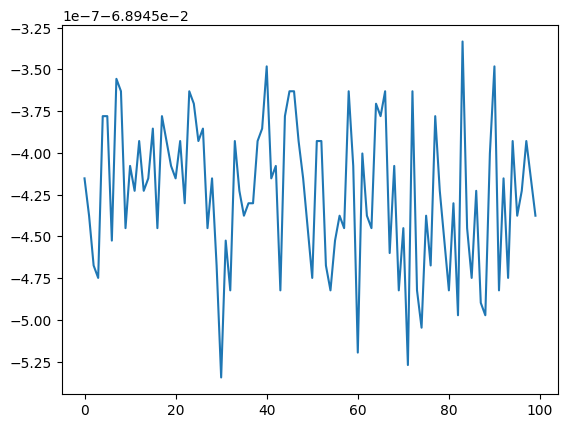

energy error:[-2.2351742e-08]
energy_error8:-0.16121873039772927


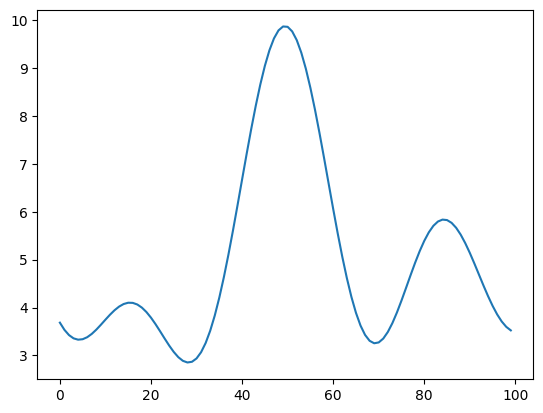

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


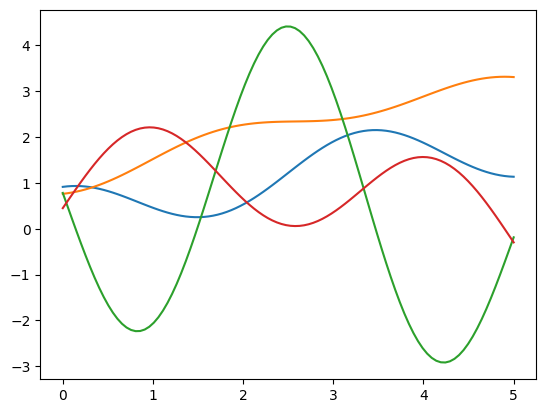

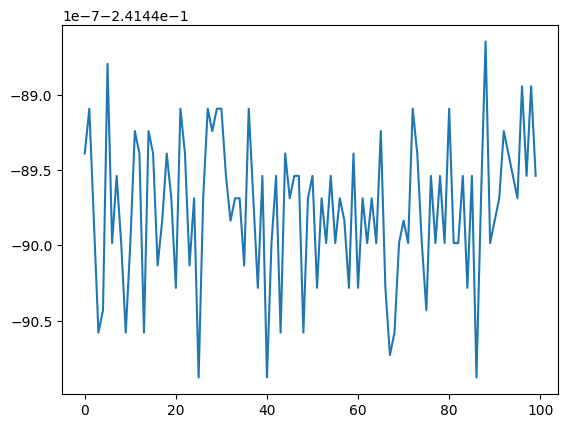

energy error:[-1.4901161e-08]
energy_error9:-0.16600075009760396


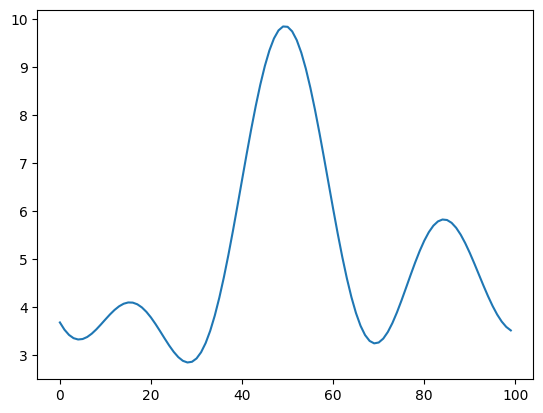

eq_error:[np.float64(-0.15736988909905714), np.float64(-0.1503445251754032), np.float64(-0.15289664332588826), np.float64(-0.14957883554955398), np.float64(-0.14693782726418503), np.float64(-0.15216917819311693), np.float64(-0.17381268425790397), np.float64(-0.16156277001094566), np.float64(-0.16121873039772927), np.float64(-0.16600075009760396)] net_error:[array([2.9802322e-08], dtype=float32), array([1.4901161e-08], dtype=float32), array([0.], dtype=float32), array([2.9802322e-08], dtype=float32), array([-2.4214387e-08], dtype=float32), array([4.4703484e-08], dtype=float32), array([0.], dtype=float32), array([-1.1920929e-07], dtype=float32), array([-2.2351742e-08], dtype=float32), array([-1.4901161e-08], dtype=float32)]
eq_error:0.15718918333713874, std: 0.008017892788281156
net_error:2.9988587613161144e-08, std: 4.3746791078547176e-08


In [8]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
eq_error = []
net_error = []
for trial in range(num_trials):
  l_nn.load_state_dict(torch.load("./model/lnn_ms_min_{}".format(trial), map_location=device))
  l_nn.eval()
  teval = torch.linspace(0.0,5.0,100)
  #x0 = np.random.uniform(low=0.0, high=1.0, size=2)
  #x0 = np.random.rand(4)
  x0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  print(x0)
  dt = teval[1]-teval[0]
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  l_nn.eval()
  l_nn.cpu()
  def fvec_np(x,t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = l_nn.forward(x).squeeze(0)
      output = torch.matmul(A, output)
      output = output.squeeze(0)
      return output.detach().cpu().numpy() 
  res = scipy.integrate.odeint(fvec_np,x0,teval)

  plt.plot(teval,res[:,0])
  plt.plot(teval,res[:,1])
  plt.plot(teval,res[:,2])
  plt.plot(teval,res[:,3])
  plt.show()
    
  # energy function
  tres = torch.tensor(res, dtype=torch.float, requires_grad=True)
  net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
  net_energy = net_energy.detach().cpu().numpy()
  plt.plot(net_energy)
  plt.show()
  net_energy_error=net_energy[99]-net_energy[0]
  print("energy error:{}".format(net_energy_error))
    
  energy = np.square(res[:,2])/(2*m1) + np.square(res[:,3])/(2*m2) + k1*np.square((res[:,0]-l1))/2 + k2*np.square((res[:,1]-res[:,0]-l2))/2
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)
  net_error.append(net_energy_error)
print("eq_error:{}".format(eq_error),"net_error:{}".format(net_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))
print("net_error:{}, std: {}".format(np.mean(np.abs(net_error)), np.std(net_error)))   

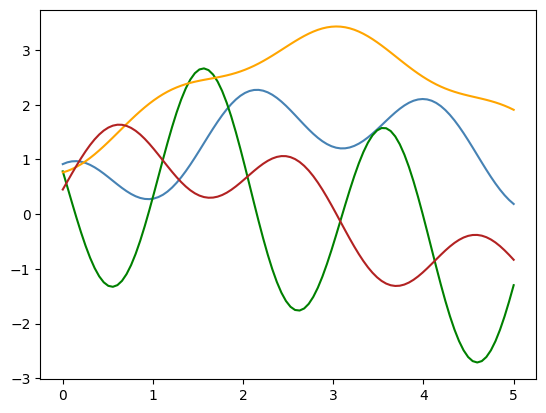

In [9]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

x1_init = np.random.randn(1)
x2_init = np.random.randn(1)
#print(x1)
v1_init = np.random.randn(1)
v2_init = np.random.randn(1)
state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  dv1dt = sol['y'][0], sol['y'][1]
  dv2dt = sol['y'][2], sol['y'][3]
  p1 = dv1dt[0]
  p2 = dv1dt[1]
  v1 = dv2dt[0]
  v2 = dv2dt[1]
  plt.plot(tval, p1, 'steelblue')
  plt.plot(tval, v1, 'g')
  plt.plot(tval, p2, 'orange')
  plt.plot(tval, v2, 'firebrick')
  plt.show()


